# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта** - построить модель, которая будет определять рыночную стоимость автомобиля.

**Задачи проекта:**

***1)*** Загрузить данные, заполнить пропущенные значения, обработать аномалии в столбцах, при необходиомсти удалить неиформативные столбцы.

***2)*** Подготовить выборки для обучения моделей.

***3)*** Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.

***4)*** Проанализировать время обучения, время предсказания и качество моделей.

***5)*** Выбрать лучшую модель, Опираясь на критерии заказчика:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

***6)*** Проверить качество лучшей модели на тестовой выборке.

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3 -q  ## Установка версии sklearn

!pip install phik -q
import phik
from phik import resources, report

!pip install category_encoders -q
from category_encoders import MEstimateEncoder


ERROR: Invalid requirement: '##'


In [2]:
import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from random import randint
from sklearn. linear_model import Ridge
from sklearn. linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from tqdm import tqdm_notebook

In [3]:
# Снимаем ограничения на количесвто столбцов, которые будут выводиться при обращении к датафреймам
pd.set_option('display.max_columns', None)  

# Задаем количество знаков после запятой для всех значений в датафрейме
pd.set_option('float_format', '{:.2f}'.format) 


In [4]:
#Загрузим данные
data_main = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')



In [5]:
#Выведем первые 5 строк
display(data_main.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим число строк, столбцов, информацию о типах данных в столбцах и количестве заполненных значений.

In [6]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Типы данных в двух столбцах можно поменять: в столбце 'Repaired' могут быть 2 значения: yes, no (True, False). Была машина в ремонте или нет - возможны только 2 варианта.

Дата последней активности представлена типом object - здесь пнужно заменить тип данных на date, если нужно оставить этот столбец. То же самое с датой создания анкеты: если оставить этот столбец, то тип данных нужно перевести в date.

Остальные типы данных указаны корректно.

Перед обработкой данных создадим копию исходного датафрейма:


In [7]:
df = data_main.copy(deep=True)

***Удаление неинформативных значений***

Согласно требованиям заказчика, прогноз рыночной цены осуществляется на основании технических характеристик, комплектации и цены. Поэтому имеет смысл удалить столбцы, не относящиеся к техническим характеристикам, копмлектации и цене:

- RegistrationMonth — месяц регистрации автомобиля;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.


In [8]:
#Столбцы для удаления:
columns_to_drop = ['RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

In [9]:
df = df.drop(columns_to_drop, axis=1)

Поменяем типы данных в столбцах

***1)*** DateCrawled  -  переведем в тип date;

***2)*** Поменяем тип данных в стобце Repaired на boolean.

In [10]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])

Поскольку именно возраст (в годах) влияет на стоимость автомобиля, а полная дата со временем не принципиальна, имеет смысл извлечь из столбца с датой создания анкеты DateCrawled) только год.

In [11]:
df['DateCrawled'] = df['DateCrawled'].dt.year

In [12]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2016,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Заменим значения в столбце Repaired на True False.

In [13]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [14]:
df['Repaired'] = df['Repaired'].map({'yes': True, 'no': False}) 

После обработки пропусков переведем тип данных в столбце Repaired в boolean

In [15]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2016,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,True
2,2016,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,False
4,2016,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,False


***Удаление аномальных значений***

Удалить аномальные значения нужно ***перед*** обработкой пропусков, чтобы при заполнении синтетическими расчетными данными пропусков аномалии не искажали данные. 

Создадим таблицу с пропущенными значениями.

In [16]:
empty_values = df.isna().sum().to_frame(name="empty_value").query("empty_value > 0")
display(empty_values)

,empty_value
VehicleType,37490
Gearbox,19833
Model,19705
FuelType,32895
Repaired,71154


Посчитаем процент пропусков.

In [17]:
empty_values['rate'] = empty_values['empty_value']/df.shape[0]

In [18]:
display(empty_values)

,empty_value,rate
VehicleType,37490,0.11
Gearbox,19833,0.06
Model,19705,0.06
FuelType,32895,0.09
Repaired,71154,0.20


Выведем статистику по количественным признакам.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DateCrawled,354369.00,2016.00,0.00,2016.00,2016.00,2016.00,2016.00,2016.00
Price,354369.00,4416.66,4514.16,0.00,1050.00,2700.00,6400.00,20000.00
RegistrationYear,354369.00,2004.23,90.23,1000.00,1999.00,2003.00,2008.00,9999.00
Power,354369.00,110.09,189.85,0.00,69.00,105.00,143.00,20000.00
Kilometer,354369.00,128211.17,37905.34,5000.00,125000.00,150000.00,150000.00,150000.00


В таблице со статистикой видим аномалии в строках:

***1)*** с нулевой стоимостью автомобиля;

***2)*** с годом регистрации автомобиля 1000 и 9999;

***3)*** с нулевым числом лошадиных сил и максимльным числом лошадиных сил 20000 (зугуглила, что максимальное число лошадиных сил 1600).

Пролверим число строк с аномалиями.



In [20]:
print('Число строк с ценой менее 50 евро :', df[df['Price'] < 50]['Price'].count())
print('Число строк с мощностью меньше 25 лошадинных сил: ', df.query('25 >= Power')['Power'].count())
print('Число строк с мощностью больше 1600 лошадиных сил: ', df.query('Power > 1600')['Power'].count())
print('Число строк с годами выпуска авто раньше 1930 года и позже 2024 года:',
      df.query('RegistrationYear <= 1930 or RegistrationYear > 2024')['RegistrationYear'].count())

Число строк с ценой менее 50 евро : 12423
Число строк с мощностью меньше 25 лошадинных сил:  40764
Число строк с мощностью больше 1600 лошадиных сил:  179
Число строк с годами выпуска авто раньше 1930 года и позже 2024 года: 291


Число строк с ценой менее 50 евро - 3,5%, не очень большой процент, но столь низкая цена может негативно сказаться на качестве прогноза. Удалим эти строки.

Число строк с не корректными годами выпуска ничтожно мало по сравнению с размером датафрейма, их можно удалить.

Число строк с аномальными размерами мощностей существенно - 11,5%. Заменим значения с аномалиями с втолбце с мощностью на NaN и затем заполним эти пропуски медианными значениями по каждому бренду.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  int32 
 1   Price             354369 non-null  int64 
 2   VehicleType       316879 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             334664 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  Repaired          283215 non-null  object
dtypes: int32(1), int64(4), object(6)
memory usage: 28.4+ MB


In [22]:
df = df[df['Price']>=50]
df = df[(df['RegistrationYear'] > 1930) & (df['RegistrationYear'] <= 2016)]

Заменим аномальные значения в столбце Power на NaN:

In [23]:
df.loc[df['Power'] <= 25, 'Power'] = np.nan
df.loc[df['Power'] > 1600, 'Power'] = np.nan

**Заполнение пропусков**



Посчитаем число и процент пропусков в столбцах после работы с аномалиями.

In [24]:
empty_values = df.isna().sum().to_frame(name="empty_value").query("empty_value > 0")
display(empty_values)

,empty_value
VehicleType,19219
Gearbox,14905
Power,32664
Model,15273
FuelType,23432
Repaired,58882


In [25]:
empty_values['rate'] = empty_values['empty_value']/df.shape[0]
display(empty_values)

,empty_value,rate
VehicleType,19219,0.06
Gearbox,14905,0.05
Power,32664,0.10
Model,15273,0.05
FuelType,23432,0.07
Repaired,58882,0.18


Перед заполнением пропусков проверим датасет на наличие неявных пропусков 'unknown' - в столбце модель 250 уникальных значений, там могли "скрыться" пропуски.

In [26]:
df = df.replace('unknown', np.nan) 

Создадим класс для замены пропусков. Пропуски в данных типа object заменим наиболее популярным значением этой марки, пропуски в данных числового типа заменим медианным значением марки.

In [27]:
class filling_gaps:
    def odject_type(self, column_1, column_2, data=df):
        data[column_1] = data.groupby(column_2, dropna = False)[column_1].transform(
            lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))
 


    def numerical_type(self, column_1, column_2, data=df):
        data[column_1] = data[column_1].replace(0, np.nan)\
        .fillna(data.groupby(column_2, dropna = False)[column_1].transform(
            lambda x: x.fillna((x.median() if not pd.isna(x.median()) else np.nan))))
    

In [28]:
filling = filling_gaps()

***Пропуски в столбце VehicleType***


In [29]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [30]:
filling.odject_type('VehicleType', 'Model')

***Пропуски в столбце GearBox***

Перед заполнением пропусков посмотрим уникальные значения столбца.

In [31]:
df['Gearbox'].value_counts()

Gearbox
manual    250404
auto       62833
Name: count, dtype: int64

In [32]:
filling.odject_type('Gearbox', 'Model')

***Пропуски в столбце Power***



In [33]:
filling.numerical_type('Power', 'Model')

In [34]:
empty_values = df.isna().sum().to_frame(name="empty_value").query("empty_value > 0")
display(empty_values)

,empty_value
Power,1
Model,15273
FuelType,23432
Repaired,58882


***Пропуски в столбце Model***

Пропуски в столбце Model заполним самым популярным значением по соответствующему бренду.

In [35]:
df['Model'].nunique()

250

In [36]:
filling.odject_type('Model', 'Brand')

***Пропуски в столбце FuelType***

заполним самым популярным типом топлива по соответсвующей модели.

In [37]:
filling.odject_type('FuelType', 'Model')

***Пропуски в столбце Repaired***

Здесь 20% пропусков - это довольно много, заполнить одним значением не корректно, связать наличие ремонта с каким-то параметром тоже проблематично. Заполним пропуски с помощью randomchoice.

In [38]:
df['Repaired'] = df[ 'Repaired'].fillna(np.random.choice(df['Repaired'].dropna()))

In [39]:
empty_values = df.isna().sum().to_frame(name="empty_value").query("empty_value > 0")
display(empty_values)

,empty_value
Power,1


Удалим одну строку с нулевой ценой.

In [40]:
df = df[df['Power'].notna()]

In [41]:
empty_values = df.isna().sum().to_frame(name="empty_value").query("empty_value > 0")
display(empty_values)

,empty_value


***Добавление дополнительного столбца***

Год выгрузки анкеты во всех строках одинаковый (2016), поэтому столбец DateCrawled не информативен. Имеет смысл добавить в таблицу столбец с возрастом авто (2016 минус год регистрации), а столбец DateCrawled убрать.

In [42]:
df['age'] = df['DateCrawled'] - df['RegistrationYear']


C:\Users\babay\AppData\Local\Temp\ipykernel_4276\551863182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['DateCrawled'] - df['RegistrationYear']


In [43]:
df = df.drop('DateCrawled', axis=1)

In [44]:
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,age
0,480,sedan,1993,manual,101.00,golf,150000,petrol,volkswagen,False,23
1,18300,coupe,2011,manual,190.00,a4,125000,gasoline,audi,True,5
2,9800,suv,2004,auto,163.00,grand,125000,gasoline,jeep,False,12
3,1500,small,2001,manual,75.00,golf,150000,petrol,volkswagen,False,15
4,3600,small,2008,manual,69.00,fabia,90000,gasoline,skoda,False,8


Посчитаем, какой объем данных удалили при обработке аномалий и пропусков.

In [45]:
percent = (1 - (df.shape[0]/data_main.shape[0]))*100

print(f'При обработке аномалий и пропусков удалили {percent:.2f} % данных.')

При обработке аномалий и пропусков удалили 7.40 % данных.


***Корректировка названий столбцов***

Приведем названия столбцов к стилю snake для удобства дальнейшей работы.

In [46]:
df = df.rename(columns={
    'Price' : 'price',
    'VehicleType' : 'vehicle_type',
    'RegistrationYear' : 'registration_year',
    'Gearbox' : 'gearbox',
    'Power' : 'power',
    'Model' : 'model',
    'Kilometer' : 'odometer',
    'FuelType' : 'fuel_type',
    'Brand' : 'brand',
    'Repaired' : 'repaired'})

In [47]:
display(df.head())

,price,vehicle_type,registration_year,gearbox,power,model,odometer,fuel_type,brand,repaired,age
0,480,sedan,1993,manual,101.00,golf,150000,petrol,volkswagen,False,23
1,18300,coupe,2011,manual,190.00,a4,125000,gasoline,audi,True,5
2,9800,suv,2004,auto,163.00,grand,125000,gasoline,jeep,False,12
3,1500,small,2001,manual,75.00,golf,150000,petrol,volkswagen,False,15
4,3600,small,2008,manual,69.00,fabia,90000,gasoline,skoda,False,8


In [48]:
display(df.duplicated().sum())
(df.duplicated().sum())/df.shape[0]

56255

0.17143545000472357

В таблице получилось 50 тыс дубликатов, что составляет 15% от датасета. Избавимся от них.

In [49]:
df = df.drop_duplicates()

In [50]:
df.duplicated().sum()

0

Посчитаем, сколько данных "ушло" после обработки пропусков и удаления дубликатов.

In [51]:
percent = (1 - (df.shape[0]/data_main.shape[0]))*100

print(f'При обработке аномалий, пропусков и удаления дубликатов удалили {percent:.2f} % данных.')

При обработке аномалий, пропусков и удаления дубликатов удалили 23.28 % данных.


**Выводы по итогам предобработки данных:**

***1)*** Удалили неинформативные столбцы, не относящиеся к техническим характеристикам, копмлектации, цене.

***2)*** Поменяли типы данных в столбцах DateCrawled на date, в стобце Repaired - на boolean.

***3)*** Обработали аномалии в столбцах Price, RegistrationYear, Power.

***4)*** Заполнили пропуски в категориальных столбцах VechileType, GearBox, Model, FuelType наиболее популярными значениям по соответствующим брендам. Пропуски в столбце Repaired заполнили с помощью randomchoice. Пропуски в столбце с количественным признаком Power заполнили медианными значениями по соответсвующим брендам.

В процессе удаления пропусков удалили 7,4% строк - многовато, но оставлять машины стоимостью менее 50 евро и авто с некорректным годом регистрации хуже, т к автомобили со столь низкой ценой это явные аномалии. Оставить их - значит сильно искжать статистику и качество предсказаний. 
По итогам полной обработки данных удалили 23,3% данных - из них 17% удаленных строк - это полные дубликаты.  

***5)*** Привели стиль названий столбцов к общепринятому виду.


Для подготовки данных и построения моделей сделаем 

**Корреляционный анализ**


Построим матрицу корреляции Phik

In [52]:
df_phik = df[['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'odometer',\
              'fuel_type', 'brand', 'repaired', 'age']]
corr_matrix_df = df_phik.phik_matrix(interval_cols = ['price', 'registration_year', 'power',
                                                                      'odometer', 'age'])
                                                    
display(corr_matrix_df)

,price,vehicle_type,registration_year,gearbox,power,model,odometer,fuel_type,brand,repaired,age
price,1.00,0.26,0.59,0.30,0.36,0.57,0.30,0.24,0.36,0.32,0.59
vehicle_type,0.26,1.00,0.15,0.27,0.21,0.91,0.18,0.32,0.63,0.07,0.15
registration_year,0.59,0.15,1.00,0.08,0.08,0.60,0.35,0.21,0.39,0.14,1.00
gearbox,0.30,0.27,0.08,1.00,0.48,0.64,0.04,0.14,0.52,0.04,0.08
power,0.36,0.21,0.08,0.48,1.00,0.55,0.06,0.07,0.38,0.05,0.08
model,0.57,0.91,0.60,0.64,0.55,1.00,0.44,0.55,1.00,0.13,0.60
odometer,0.30,0.18,0.35,0.04,0.06,0.44,1.00,0.16,0.28,0.10,0.35
fuel_type,0.24,0.32,0.21,0.14,0.07,0.55,0.16,1.00,0.32,0.03,0.21
brand,0.36,0.63,0.39,0.52,0.38,1.00,0.28,0.32,1.00,0.08,0.39
repaired,0.32,0.07,0.14,0.04,0.05,0.13,0.10,0.03,0.08,1.00,0.14


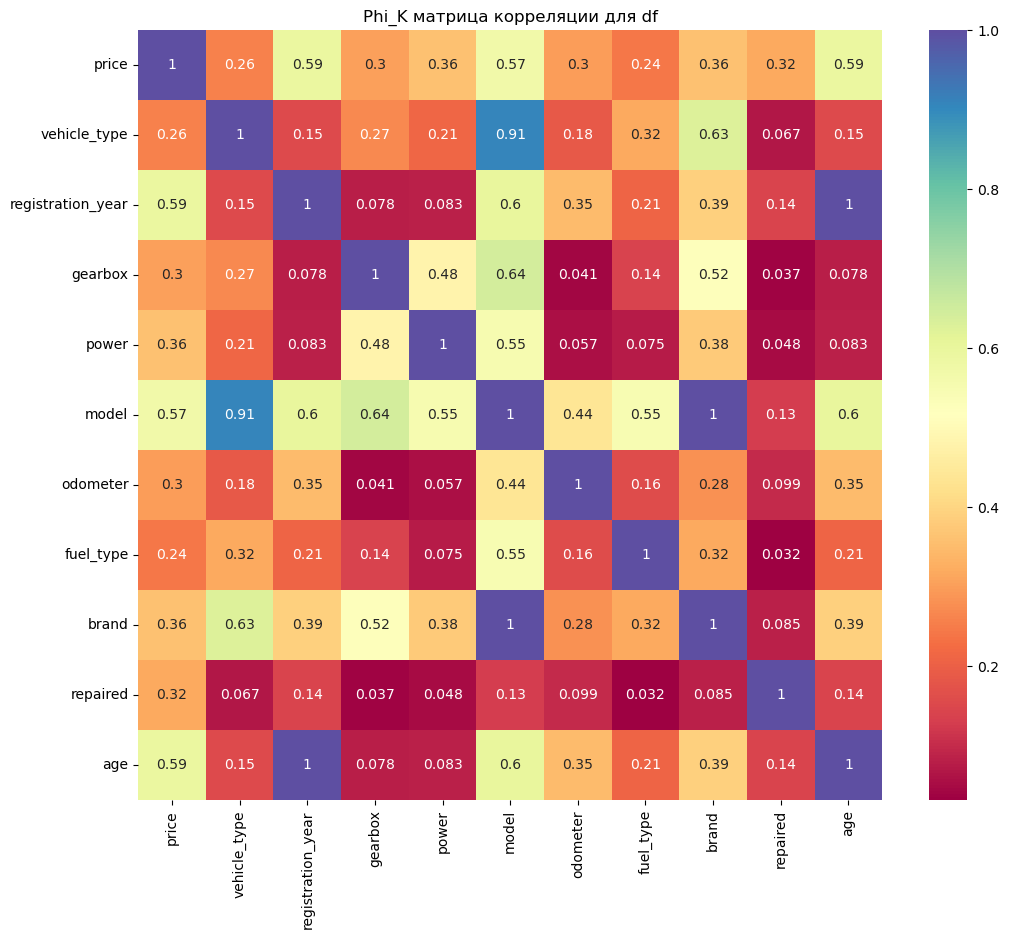

In [54]:
# Визуализация матрицы корреляции phik

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_df, annot=True, cmap='Spectral')
plt.title('Phi_K матрица корреляции для df')
plt.show()

Удалим столбец с registration year, т к мы его использовали для определения возраста, и у него такая же корреляция с целевым признаком, как у Age.

In [55]:
df = df.drop('registration_year', axis=1)

Видим так же высокую корреляцию между моделью и брендом (91%), но поскольку это не числовые признаки (связь не линейная), и оба признака информативны, не будем удалять ни один из них.

Максимальная корреляция с целевым признаком наблюдается у признака Age - 59%.

## Обучение моделей

**Подготовка признаков**

В начале подготовим признаки и обучим линейную модель, т к для обучения моделей бустинга нужно будет переводить категориальные признаки в числовой тип.

Разделим датасет на ренировочную и тестовую выборки.

In [56]:
features = df.drop(columns='price')
target = df['price']

features_train, features_test, target_train, target_test = \
            train_test_split(features, target, test_size=0.2, random_state = 42)

print(f'Размер тренировочной выборки - {target_train.shape[0]}')
print(f'Размер тестовой выборки - {target_test.shape[0]}')

Размер тренировочной выборки - 217508
Размер тестовой выборки - 54378


Разделим тренировочную выборку на обучающую и валидационную.

In [57]:
features_train, features_val, target_train, target_val = \
    train_test_split(features_train, target_train, test_size=0.2, random_state=42)
print(f'Размер обучающей выборки - {target_train.shape[0]}')
print(f'Размер валидационной выборки - {target_val.shape[0]}')

Размер обучающей выборки - 174006
Размер валидационной выборки - 43502


Будем использовать 2 кодировщика. У двух признаков - model и brand большое количество уникальных значений - 249 и 40 соответственно. При использовании OHE кодировщика возникнет 249 и 40 дополнительных столбцов.Чтобы этого избежать, для признаков model и brand будем использовать MEstimateEncoder. Для остальных категориельных признаков будем использовать OHE encoder.

In [59]:
df.head()

,price,vehicle_type,gearbox,power,model,odometer,fuel_type,brand,repaired,age
0,480,sedan,manual,101.00,golf,150000,petrol,volkswagen,False,23
1,18300,coupe,manual,190.00,a4,125000,gasoline,audi,True,5
2,9800,suv,auto,163.00,grand,125000,gasoline,jeep,False,12
3,1500,small,manual,75.00,golf,150000,petrol,volkswagen,False,15
4,3600,small,manual,69.00,fabia,90000,gasoline,skoda,False,8


In [60]:
cat_col_names_ohe = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
cat_col_names_me = ['model', 'brand']
num_col_names = ['power', 'odometer', 'age']

Кодируем категориальные признаки.

In [63]:
# создадим переменную с экземпляром класса MEstimateEncoder
encoder_me = MEstimateEncoder(cols = cat_col_names_me, m=5.0)

# обучим категориальные признаки из тренировочной выборки с помощью MEstimateEncoder 
encoder_me.fit(features_train[cat_col_names_me], target_train)


#Трансформируем категориальные признаки с помощью MEstimateEncoder
features_train_me = encoder_me.transform(features_train[cat_col_names_me])
features_val_me = encoder_me.transform(features_val[cat_col_names_me])
features_test_me = encoder_me.transform(features_test[cat_col_names_me])

# получим от кодировщика список новых столбцов и сохраним в новой переменной
encoder_col_names_me = encoder_me.get_feature_names_out()

# создаём тренировочный, валидационный и тестовый датафреймы из закодированных данных
features_train_me = pd.DataFrame(features_train_me, columns=encoder_col_names_me)
features_val_me = pd.DataFrame(features_val_me, columns=encoder_col_names_me)
features_test_me = pd.DataFrame(features_test_me, columns=encoder_col_names_me)


In [65]:
# создадим переменную с экземпляром класса OneHotEncoder()
encoder_ohe = OneHotEncoder(drop = 'first', sparse_output = False)

# обучим и трансформируем категориальные признаки из тренировочной выборки с помощью  OneHotEncoder
features_train_ohe = encoder_ohe.fit_transform(features_train[cat_col_names_ohe])

# выполним преобразование категориальных признаков в валидационной и тестовой выборках
features_val_ohe = encoder_ohe.transform(features_val[cat_col_names_ohe])
features_test_ohe = encoder_ohe.transform(features_test[cat_col_names_ohe])


# получим от кодировщика список новых столбцов и сохраните в новой переменной 
encoder_col_names_ohe = encoder_ohe.get_feature_names_out()


# создаём тренировочный, валидационный и тестовый датафреймы из закодированных данных

features_train_ohe = pd.DataFrame(features_train_ohe, columns=encoder_col_names_ohe)
features_val_ohe = pd.DataFrame(features_val_ohe, columns=encoder_col_names_ohe)
features_test_ohe = pd.DataFrame(features_test_ohe, columns=encoder_col_names_ohe)


Отмасштабируем количественные признаки во всех выборках.

In [66]:
# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
features_train_scaled = scaler.fit_transform(features_train[num_col_names])

# выполним преобразование количественных признаков в валидационной и тестовой выборках
features_val_scaled = scaler.transform(features_val[num_col_names])
features_test_scaled = scaler.transform(features_test[num_col_names])

# создаём тренировочный, валидационный и тестовый датафреймы из отмасштабированных данных
features_train_scaled = pd.DataFrame(features_train_scaled, columns=num_col_names)
features_val_scaled = pd.DataFrame(features_val_scaled, columns=num_col_names)
features_test_scaled = pd.DataFrame(features_test_scaled, columns=num_col_names)

In [67]:
[num_col_names], features_train.columns.to_list()

([['power', 'odometer', 'age']],
 ['vehicle_type',
  'gearbox',
  'power',
  'model',
  'odometer',
  'fuel_type',
  'brand',
  'repaired',
  'age'])

In [68]:
display(features_train_scaled.head())

,power,odometer,age
0,-1.06,-2.25,-0.33
1,0.16,0.61,0.10
2,0.23,0.61,-0.18
3,-1.52,-2.51,1.10
4,-1.64,-1.99,2.52


In [69]:
display(features_val_scaled.head())

,power,odometer,age
0,0.82,0.61,0.39
1,1.85,0.61,1.10
2,-0.07,0.61,0.53
3,-0.58,-1.21,-0.47
4,-0.29,0.61,-0.76


In [70]:
display(features_test_scaled.head())

,power,odometer,age
0,0.45,0.61,1.10
1,0.36,-1.21,-1.18
2,0.48,0.61,-0.04
3,1.17,-0.04,-0.76
4,-0.12,0.61,1.10


Объединяем кодированные и масштабированные данные в тренировочный, валидационный и тестовый датафреймы

In [71]:
features_train = pd.concat([features_train_ohe.reset_index(), features_train_me.reset_index(),\
                            features_train_scaled.reset_index()], axis=1)
features_val = pd.concat([features_val_ohe.reset_index(), features_val_me.reset_index(),\
                          features_val_scaled.reset_index()], axis=1)
features_test = pd.concat([features_test_ohe.reset_index(), features_test_me.reset_index(),\
                           features_test_scaled.reset_index()], axis=1)

In [72]:
#определим метод кросс-валидации для оценки модели
cv = RepeatedKFold(n_splits= 10 , n_repeats= 3 , random_state= 1 )

model_ridge = RidgeCV(alphas = [0.1, 0.21, 0.01], cv=cv, scoring='neg_root_mean_squared_error')

#fit model
model_ridge.fit(features_train, target_train)
best_alpha = model_ridge.alpha_
best_estimator = Ridge(alpha=best_alpha)

#обучаем лучшую модель
start_time = time.time()
best_estimator.fit(features_train, target_train)

end_time = time.time()

training_time_ridge = end_time - start_time
training_time_ridge = round(training_time_ridge, 2)

# Время обучения модели RidgeCV
print("Время обучения модели RidgeCV: %s секунд" % training_time_ridge)

# Время предсказания модели RidgeCV
start_time = time.time()
target_pred_ridge = best_estimator.predict(features_test)
end_time = time.time()
prediction_time_ridge = end_time - start_time
prediction_time_ridge = round(prediction_time_ridge, 2)
print("Время предсказания RidgeCV: %s секунд" % prediction_time_ridge)

# Оценка качества модели RidgeCV на валидационной выборке
rmse_ridge = mean_squared_error(target_val, best_estimator.predict(features_val), squared=False)
print("RMSE RidgeCV на валидационной выборке: %.2f" % rmse_ridge)

C:\Users\babay\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.68472e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\babay\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.58458e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\babay\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.59016e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\babay\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.58143e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\babay\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

Время обучения модели RidgeCV: 0.05 секунд
Время предсказания RidgeCV: 0.01 секунд
RMSE RidgeCV на валидационной выборке: 3024.58


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Для обучения моделей бустинга заменим тип данных на числовой. 

In [73]:
df['vehicle_type'] = df['vehicle_type'].astype('category').cat.codes
df['gearbox'] = df['gearbox'].astype('category').cat.codes
df['model'] = df['model'].astype('category').cat.codes
df['fuel_type'] = df['fuel_type'].astype('category').cat.codes
df['brand'] = df['brand'].astype('category').cat.codes
df['repaired'] = df['repaired'].astype('category').cat.codes

Подготовим признаки и разделим данные на обучающую и тестовую выборки.

In [74]:
features = df.drop(columns='price')
target = df['price']

features_train, features_test, target_train, target_test = \
            train_test_split(features, target, test_size=0.2, random_state = 42)

print(f'Размер обучающей выборки - {target_train.shape[0]}')
print(f'Размер тестовой выборки - {target_test.shape[0]}')

Размер обучающей выборки - 217508
Размер тестовой выборки - 54378


Разделим тренировочную выборку на тренировочную и валидационную.

In [75]:
features_train, features_val, target_train, target_val = \
    train_test_split(features_train, target_train, test_size=0.2, random_state=42)
print(f'Размер обучающей выборки - {target_train.shape[0]}')
print(f'Размер валидационной выборки - {target_val.shape[0]}')

Размер обучающей выборки - 174006
Размер валидационной выборки - 43502


**Модель LightGBM**

Зададим следующие параметры модели:

- boosting_type - 'gbdt' (Gradient Boosting Decision Tree), используем традиционную технику градиентного бустинга;
- objective - 'regression', т к мы прогнозмруем непрерывнй признак (цену автомобилей);
- metric - 'RMSE';
- num_leaves - 31;
- learning_rate (скорость обучения) - 0.05;
- feature_fraction - 0.9 (LightGBM случайным образом выбирать 90% фичей в начале построения каждого дерева);
- bagging_fraction (доля данных, подлежащих случайной выборке на каждой итерации, помогает предотвратить переобучение) - 0.8;
- bagging_freq - 5;
- verbose - 0.
    
    

In [82]:
start_time = time.time()

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

lgb_train = lgb.Dataset(features_train, target_train)
lgb_val = lgb.Dataset(features_val, target_val)

model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_val])
                     # stopping_rounds=50,
                      #verbose=100)

end_time = time.time()
training_time_lgb = end_time - start_time
training_time_lgb = round(training_time_lgb, 2)

# Время обучения модели LightGBM
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgb = model_lgb.predict(features_test)
end_time = time.time()
prediction_time_lgb = end_time - start_time
prediction_time_lgb = round(prediction_time_lgb, 2)
print("Время предсказания LightGBM: %s секунд" % prediction_time_lgb)

# Оценка качества модели LightGBM на валидационной выборке
rmse_lgb = mean_squared_error(target_val, model_lgb.predict(features_val), squared=False)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)

Время обучения LightGBM: 3.15 секунд
Время предсказания LightGBM: 0.36 секунд
RMSE LightGBM на валидационной выборке: 1718.07


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Модель CatBoostRegressor**

Зададим следующие параметры:

- iterations (максимальное количество построенных деревьев) - 1000;
- learning_rate=0.1, скорость обучения, которая определяет насколько быстро или медленно модель будет учиться;
- depth (глубина дерева) - 6;
- early_stopping_rounds = 50, количество итераций для остановки, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной.
                                   
                                   

In [83]:
# Обучение модели CatBoostRegressor
start_time = time.time()

model_catboost = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.1,
                                   depth=6,
                                   loss_function='RMSE',
                                   random_state=42)

model_catboost.fit(features_train, target_train, eval_set=(features_val, target_val), verbose=100, early_stopping_rounds=50)

end_time = time.time()
training_time_catboost = end_time - start_time
training_time_catboost = round(training_time_catboost, 2)

# Время обучения модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % training_time_catboost)

# Время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_catboost = model_catboost.predict(features_test)
end_time = time.time()
prediction_time_catboost = end_time - start_time
prediction_time_catboost = round(prediction_time_catboost, 2)
print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_catboost)

# Оценка качества модели CatBoostRegressor на валидационной выборке
rmse_catboost = mean_squared_error(target_val, model_catboost.predict(features_val), squared=False)
print("RMSE CatBoostRegressor на валидационной выборке: %.2f" % rmse_catboost)

0:	learn: 4338.6846937	test: 4346.1088418	best: 4346.1088418 (0)	total: 151ms	remaining: 2m 30s
100:	learn: 1897.9565672	test: 1923.0364308	best: 1923.0364308 (100)	total: 913ms	remaining: 8.12s
200:	learn: 1806.2143170	test: 1844.5020292	best: 1844.5020292 (200)	total: 1.71s	remaining: 6.8s
300:	learn: 1758.6694232	test: 1808.0352389	best: 1808.0352389 (300)	total: 2.5s	remaining: 5.8s
400:	learn: 1728.0801561	test: 1787.9137347	best: 1787.9137347 (400)	total: 3.28s	remaining: 4.9s
500:	learn: 1702.9648781	test: 1773.5316717	best: 1773.5316717 (500)	total: 4.08s	remaining: 4.07s
600:	learn: 1683.7294532	test: 1762.1896417	best: 1762.1724440 (599)	total: 4.89s	remaining: 3.24s
700:	learn: 1666.1633911	test: 1752.4402179	best: 1752.4402179 (700)	total: 5.79s	remaining: 2.47s
800:	learn: 1652.9381697	test: 1746.0212564	best: 1746.0212564 (800)	total: 6.72s	remaining: 1.67s
900:	learn: 1639.7850517	test: 1740.4173618	best: 1740.4173618 (900)	total: 7.58s	remaining: 833ms
999:	learn: 1628.

C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Анализ моделей

In [84]:
results = pd.DataFrame({'Модель': ['LightGBM', 'CatBoostRegressor', 'RidgeCV'],
                        'Время обучения, секунд': [training_time_lgb, training_time_catboost, training_time_ridge],
                        'Время предсказания, секунд': [prediction_time_lgb, prediction_time_catboost, prediction_time_ridge],
                        'RMSE': [rmse_lgb, rmse_catboost, rmse_ridge]})

# Вывод результатов
results

,Модель,"Время обучения, секунд","Время предсказания, секунд",RMSE
0,LightGBM,3.15,0.36,1718.07
1,CatBoostRegressor,8.65,0.01,1735.09
2,RidgeCV,0.05,0.01,3024.58


**Выводы по анализу моделей**

***1)*** RidgeCV быстрее всех обучается и предсказывает, при этом его качество (метрика RMSE) не проходит критерий качества заказчика (RMSE = 3024 > 2500).

***2)*** LightGBM демонстрирует лучшую метрику  RMSE (1718), но самое длительное время обучения (250 секунд) и предсказания.
CatBoost так же показал высокую метрику RMSE (1735, почти такую же как LightGBM), при этом время обучения в 10 раз меньше, чем у LightGBM, а предсказания на 3 порядка быстрее (0,05 секунд).

***3)*** RidgeCV показал плохое качество предсказаний (максимальную метрику RMSE), но минимальное время обучения (0,19 секунд) и предсказания (0,09 секунд). 

Оптимальным вариантом является модель CatBoost, так как у этой модели лучшее соотношение результатов, важных для заказчика: метрика RMSE почти такая же, как у LightGBM (1718), а время обучения (22 секунды) и предсказания (0,05 секунд) существенно ниже, чем у LightGBM.

## Тестирование лучшей модели

In [85]:
# Оценка качества моделиCatBoost на тестовой выборке
rmse_test = mean_squared_error(target_test, model_catboost.predict(features_test), squared=False)

print("RMSE модели CatBoost на тестовой выборке: %.2f" % rmse_test)

RMSE модели CatBoost на тестовой выборке: 1699.72


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Результат работы лучшей модели CatBoost на тестовой выборке удовлетворяет требованиям заказчика.

**Итоговый вывод:**

По результатам обучения трех моделей: LightGBM, CatBoostRegressor, RidgeCV оптимальные по требованиям заказчика результаты получились у модели CatBoostRegressor. Метрика RMSE на тестовой выборке  - 1699, время обучения - 22 секунды, время предсказания - 0,05 секунд.

